## Use con37comp env

In [2]:
import sys, os, csv ,re, itertools
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interactive
import ipywidgets as widgets
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
print("local folder")
print(os.getcwd())

local folder
/Users/arielbs10/Dropbox/postdoc/projects/SAXS/manuscript2/nb


### Short instructions:
    1. Load pymol session with the ASU model. Example:
        From ~/Dropbox/postdoc/projects/SAXS/manuscript2/input run pml ASU.pdb
    2. Within the pymol session run drowN_ASUs(ASUs#) to generate an array.
    3. Within the pymol session run drow2DlatticeFotN_ASUs(ASUs#) to generate the lattice of the p6 plane symmetry for visualization purposes. 
        note both function are in ~/Dropbox/pymolscripts/pymolLattice_utils.py
    4. To generate lattice image for a given number of ASUS automatically drowN_ASUs(ASUs#,PNG=1) default 0.
    5. To generate lattice images for all lattice sizes up to the specified ASUs # use drowN_ASUs(ASUs#,PNG=2)
<img src="/Users/arielbs10/Dropbox/postdoc/projects/SAXS/manuscript2/images/array20ASUs.png" width="800" height="400">

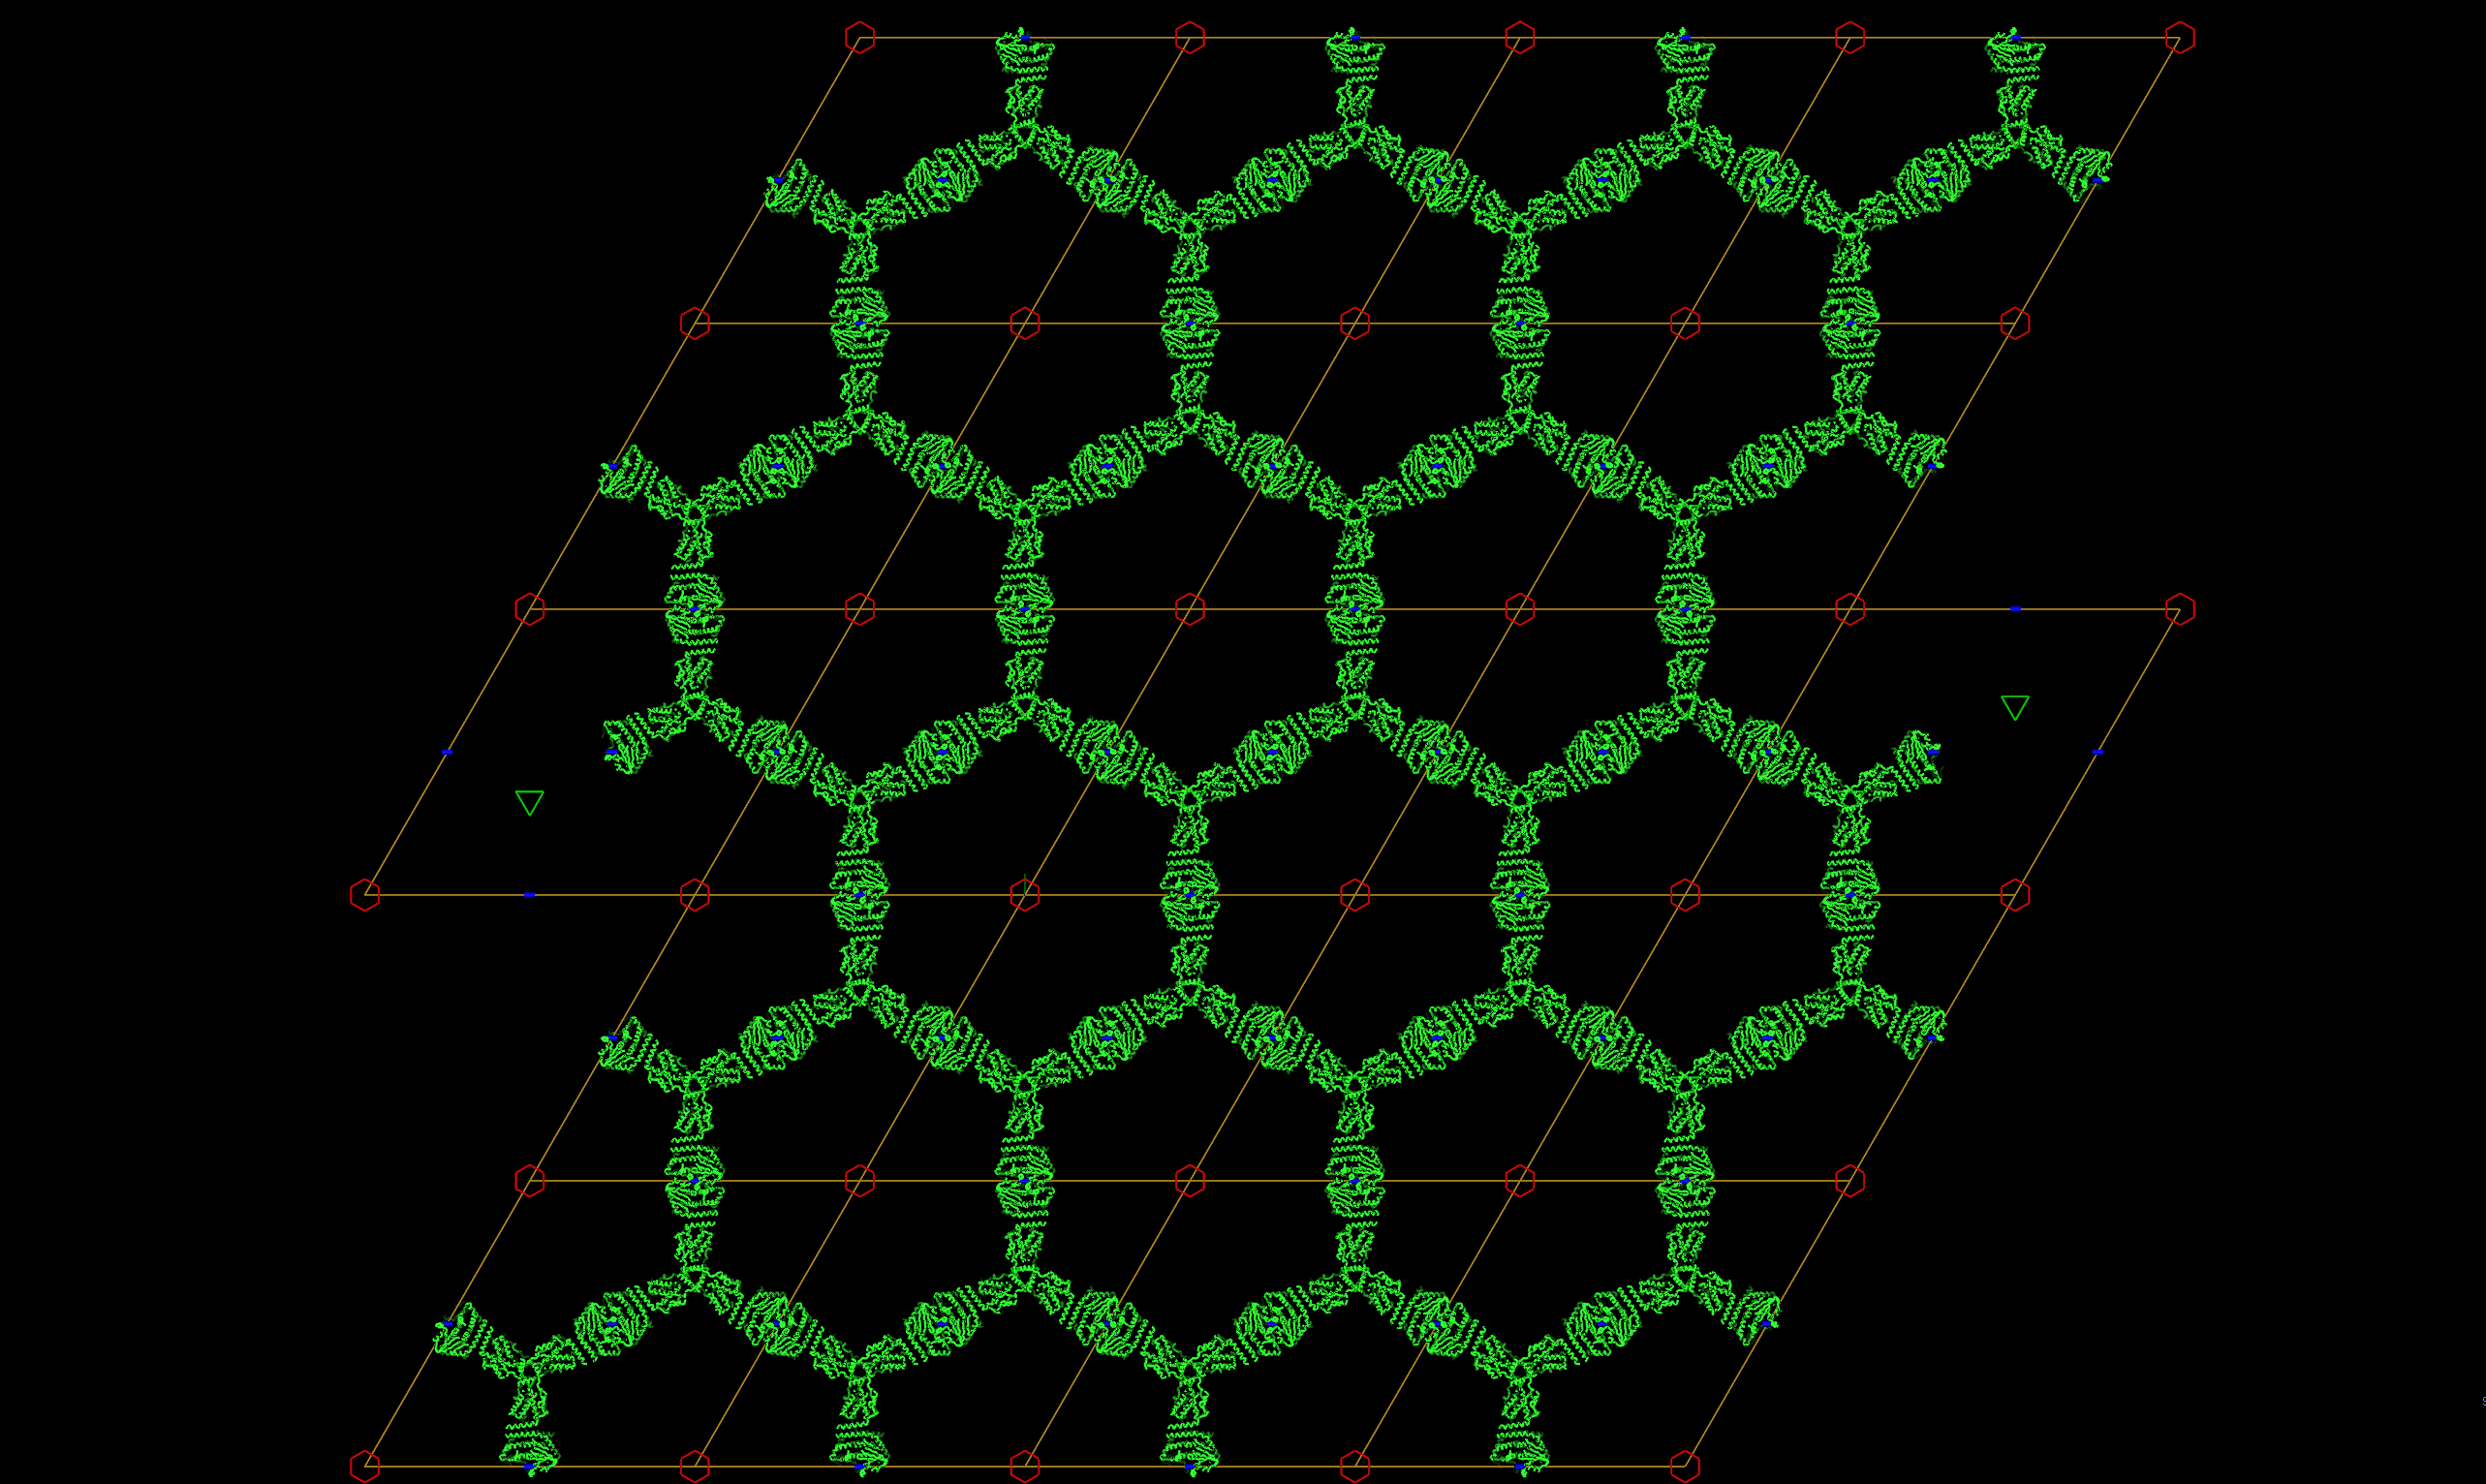

In [5]:
Image(filename='/Users/arielbs10/Dropbox/postdoc/projects/SAXS/manuscript2/sym2d_generator/data/array40ASUs.png' ,width="400", height="400")



## Protocol to generate arrays with arbitrary dimensions

The translation vector in 2D from an arbtrary origin point to any equvalent position on the lattice is defined by:
$$eq.(1)\quad \vec{R} = n_{1}\vec{a}+n_{2}\vec{b}$$
where n$_{1}$ and n$_{2}$ are any integer, and $\vec{a}$ and $\vec{b}$ are the primitive vectors. In a p6 lattice the unit cell structure is hexagonal and have rotation centers of order 2(x3), 3(x2), and 6(x1). In our model the ASU corresponds to the rotation center of order 3, does two ASUs per assymetric unit. One simple way to generate a lattice with dimensions as needed can follow a very simple protocol:
1. Choose number (N) of ASUs needed. 
2. Generate a set of n$_{1}$ and n$_{2}$ pairs, where number of pairs equal to np.ceil(N/2)
3. Generate a set of triads including (n$_{1}$, n$_{2}$,n3), where n3 a bulian, 0 - the left ASU and 1 - the right ASU which is also 180 rotated around the ASU center of mass around the Z axis.
4. Apply eq.(1) to obtain the lattice positions. 
note: unit cell spacing (UCS) is calculated as follows: $$eq.(2)\quad UCS=2*A*cos(30)/3$$ and A is a constant obtained from the design model as the distance between two arbitrary identical atoms belonging to two consecutive ASUs with similar orientation. 
5. Once a given number of ASUs is specified the minimal number of indices set of [n$_{1}$,n$_{2}$] pairs is specified. Note that in the current method the generated lattice is overall square in shape because of the way the indices are chossen. A better selection method for the unit cells and ASUs positions would allow to generate a more circular models which may be better for the SAXS prediction and has higher probablity to follow the expected assembly trajectory. 
6. A set of positions (p0) the represent the lower left corner of each UC are generated by applying eq.1 on the set of indcies from (5) using: $$ eq.(3)\quad \vec{a}=[1,0,0]$$  $$ eq.(4)\quad \vec{a}=[cos(60),sin(60),0]$$ $$  eq.(5)\quad  x_{p0},y_{p0}= [n_{1},n_{2}]\cdot[\vec{a},\vec{b}]$$
6. The position of each ASU within each UC are defined by: $$eq.(6)\quad [X_{ASU_{L}},y_{ASU_{L}}] = [x_{p0}+0.5*UCS,y_{p0}+0.5*tan(30)*UCS] $$  $$eq.(7)\quad [X_{ASU_{R}},y_{ASU_{R}}] = [x_{p0}+1*UCS,y_{p0}+1*tan(30)*UCS] $$ 
7. Orientation of the right ASU in each UC is rotated in 180 degrees around the Z axis compared to the left ASU.


In [3]:
def genLatticePos(N,A,B,C0,shape='round'):  # round
    '''
    Generating the list of lattice positions
    protocol:
    1. Given a number of latice positions devided by two (to ASUs per unit cell) find the upper bound number of unit cells needed to generae the lattice
    2. Generate list of dtype'i,i,i'
    3. select the number of unit cells needed of the provided list
    
    Inputs: N - ASUs #
            A,B - normalized lattice primitive vectors
            C0 - normalized vector to the C3 lower left ASU center from the lower left corner. 2*C0 would be to the second ASU
            shape - shape of the lattice, accepting string of either ['round','Hexagonal']
    '''
    N_UC = np.ceil(N/2).astype(int) # number of unit cells
    latticeShape = ['round','Hexagonal']
    if shape not in latticeShape:           # n is the max calue of the primitive cell indices 
        print("Input lattice shape is not specified correctly, options are ['round','Hexagonal'], returning a round lattice shape")
        shape = 'round'
    if shape=='round':
        n = np.ceil(np.power(N_UC,0.5)*2/np.sqrt(np.pi)+5).astype(int)   
    if shape=='Hexagonal':
        n = np.ceil(np.power(N_UC,0.5)).astype(int)
        
    centerIndicesVec = np.arange(n,dtype=int)- int((n-1)/2)   # generate a centered vector for the UC indices 
    UCindicesPairs = itertools.product(centerIndicesVec, repeat=2)                      # geenrate pairs of indices to specify each unit cell
    UC_ASUsIndices = np.array([(np.append(np.array(n),0), np.append(np.array(n),1)) for n in  UCindicesPairs])  # generate a double array, one for each ASU
    UC_ASUsIndices = np.reshape(UC_ASUsIndices,[UC_ASUsIndices.shape[0]*2,1,3])  # reshaping to obtain the arrays of locations 
    UC_ASUsIndices = UC_ASUsIndices.flatten()
    UC_ASUsIndices = np.reshape(UC_ASUsIndices,(int(UC_ASUsIndices.shape[0]/3),3))
    
    # ASU selection to create lattice in a given shape 
    if shape not in latticeShape:           # n is the max calue of the primitive cell indices 
        print("Input lattice shape is not specified correctly, returning a round lattice shape")
        shape = 'round'
    if shape=='round':
        p = genLatticeArray(UC_ASUsIndices,A,B,C0)
        d = np.reshape(np.sum(np.power(p,2),axis=1),[UC_ASUsIndices.shape[0],1])
        UC_ASUsIndices = np.concatenate((UC_ASUsIndices,d),axis=1)
        ind=np.argsort(UC_ASUsIndices[:,-1])
        UC_ASUsIndicesSelected=UC_ASUsIndices[ind][:N,:]   
    if shape=='Hexagonal':
        UC_ASUsIndices = np.concatenate((UC_ASUsIndices,np.reshape(np.sum(UC_ASUsIndices,axis=1),[UC_ASUsIndices.shape[0],1] )),axis=1)  # sum all the column into a forth column
        ind=np.argsort(UC_ASUsIndices[:,-1])
        UC_ASUsIndicesSelected=UC_ASUsIndices[ind][:N,:3]
        
    return UC_ASUsIndicesSelected

def genLatticeArray(arr,a,b,c0):
    latticePos = np.array([np.dot(n[:2],[a,b])+c0+c0*n[2]  for n in arr] )
    return np.append(latticePos, np.zeros((latticePos.shape[0],1)), axis=1)
    
    
def getUCp0(N,a,b,S):
    '''
    N - numer of ASUs to be imaged 
    a,b - primitive vectors
    S - unit cell spacing
    '''
    coefArray = genLatticePos(N)
    UCp0List = np.unique(coefArray[:,:2],axis=0)
    UCp0Locs = np.dot(UCp0List,[a,b])*S  
    UCp0Locs = np.append(UCp0Locs, np.zeros((UCp0Locs.shape[0],1)), axis=1)
    return UCp0List,UCp0Locs
        

In [4]:
### vectors definitions

a = np.array((1,0))
b = np.array((np.cos(60*np.pi/180),np.sin(60*np.pi/180)))
c0 = np.array((0.5,0.5*np.tan(30*np.pi/180)))
c1 = 2*c0 # np.array((np.cos(30*np.pi/180),np.sin(30*np.pi/180)))
UC_spacing = int(537*2*np.cos(30*np.pi/180)/3)

### generate lattice parameters array
NN = 150
coefArray = genLatticePos(NN,a,b,c0)  # note that coefArray[:,:,x] also determine the rotation of the ASU
latticePos = genLatticeArray(coefArray,a,b,c0)*UC_spacing
maxX = np.max(latticePos[:,0])
minX = np.min(latticePos[:,0])
maxY = np.max(latticePos[:,1])
minY = np.min(latticePos[:,1])

def f(N):
    coefArray = genLatticePos(N,a,b,c0,shape='round')  # note that coefArray[:,:,x] also determine the rotation of the ASU
    latticePos = genLatticeArray(coefArray,a,b,c0)*UC_spacing
    plt.axis([minX*1.2,maxX*1.2,minY*1.2,maxY*1.2])
    plt.scatter(latticePos[:,0],latticePos[:,1],color='b')
    plt.show()

interactive_plot = interactive(f, N=widgets.IntSlider(min=1, max=NN, step=1, value=10))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot



interactive(children=(IntSlider(value=10, description='N', max=150, min=1), Output(layout=Layout(height='350px…